## 参考

- Machine Learning in Action
- 李航--统计学习方法


In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D # registers the 3D projection
from matplotlib import pyplot as plt
from functools import wraps, partial
import time

import svmMLiA
import svm

from scipy.spatial.distance import pdist, squareform

# plot configuration
# if in jupyterlab, use this instead
# %matplotlib widget
# to view notebook on github
%matplotlib inline

%config InlineBackend.figure_formats = ['svg']
# plt.style.use('dark_background')
# happy drafting without annoying warning
plt.rcParams.update({'figure.max_open_warning': 1000})

# enable module auto reload
%load_ext autoreload
%autoreload 2

                0           1           2
count  100.000000  100.000000  100.000000
mean     4.790926    0.059057   -0.080000
std      3.103636    1.465117    1.001817
min     -0.743036   -5.766721   -1.000000
25%      1.976116   -0.573050   -1.000000
50%      3.539520   -0.009497   -1.000000
75%      8.034324    0.810767    1.000000
max      9.854303    3.964960    1.000000


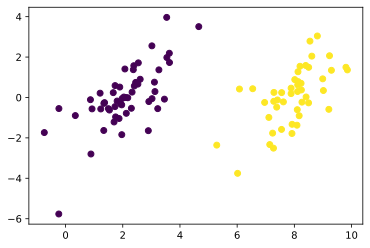

In [2]:
# we visualize a simple dataset first
def explore_simple_data():
    df = pd.read_csv('linear_separable.txt', sep='\t', header=None)
    print(df.describe())
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(df[0], df[1], c=df[2])
    
explore_simple_data()

In [3]:
def load_dataset(path):
    df = pd.read_csv(path, sep='\t', header=None)
    return df.iloc[:, :2].to_numpy(), df.iloc[:, -1].to_numpy()

def get_decision_boundary(train_data, train_label, alphas, b):
    support_vector_idx = alphas > 0

    x = np.arange(train_data[:,0].min(), train_data[:, 0].max(), 0.5)

    alphas = alphas[support_vector_idx]
    train_data = train_data[support_vector_idx]
    train_label = train_label[support_vector_idx]


    # calculate b by a support vector
    b = train_label[0] - (alphas * train_label).dot(
            (train_data * train_data[0]).sum(axis=1))

    # y coordinate on decision boundary
    y = -((alphas * train_label).dot( train_data[:, 0]) * x  + b) \
            / (alphas * train_label).dot( train_data[:, 1])

    return x, y

def visualize_dataset_with_decision_boundary(train_data, train_label, alphas, b):
    print('support vector amount:', (alphas > 0).sum())
    print('corresponding alphas:', alphas[alphas>0])
    print('b in smo:', b)

    support_vector_idx = alphas > 0

    # plot dataset
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(train_data[:,0], train_data[:,1], c=train_label)
    ax.scatter(train_data[support_vector_idx, 0],
            train_data[support_vector_idx,1], marker='x')

    line_x, line_y = get_decision_boundary(train_data, train_label, alphas, b)
    ax.plot(line_x, line_y, c='b')


support vector amount: 5
corresponding alphas: [0.14518506 0.03154863 0.18106043 0.06995522 0.2878389 ]
b in smo: [[-3.82371495]]
2.09 s ± 703 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


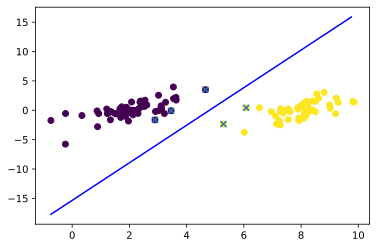

In [4]:
# test SMO algorithm by Machine Learning in Action
def test_method_by_MLiA(method):
    train_data, train_label = load_dataset('linear_separable.txt')
    

    b, alphas = method(train_data, train_label, 0.6, 1e-3, 40)
    # alphas returned is (N,1), we convert it to (N,)
    alphas = np.squeeze(np.asarray(alphas))
    
    visualize_dataset_with_decision_boundary(train_data, train_label, alphas, b)

# simple version of SMO algorithm, note that I suppress the output from smoSimple
test_method_by_MLiA(svmMLiA.smoSimple)

# check performance, this implementation is quite slow
%timeit svmMLiA.smoSimple(*load_dataset('linear_separable.txt'), 0.6, 1e-3, 40)

support vector amount: 9
corresponding alphas: [0.06961952 0.0169055  0.0169055  0.0272699  0.04522972 0.0272699
 0.0243898  0.06140181 0.06140181]
b in smo: [[-2.89901748]]
29 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


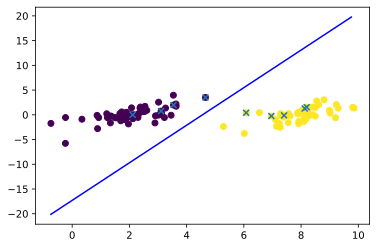

In [5]:
# test full version of SMO algortithm, note that I suppress the output from smoP
test_method_by_MLiA(svmMLiA.smoP)

# check performance, this implementation is much faster
%timeit svmMLiA.smoP(*load_dataset('linear_separable.txt'), 0.6, 1e-3, 40)

<timeit  "_solve_alphas": 0.005387067794799805 s>
support vector amount: 3
corresponding alphas: [0.19898091 0.16411218 0.36309309]
b in smo: -128.92637470903892
5.67 ms ± 26.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


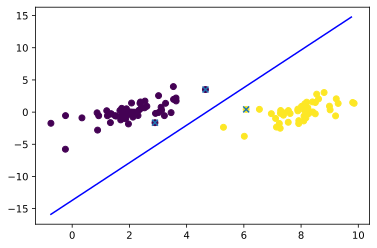

In [6]:
# test my implementation
def test_my_svm_smo():
    train_data, train_label = load_dataset('linear_separable.txt')
    s = svm.SVMBySMO(train_data, train_label, 0.6, 1e-3, max_iter=40)
    visualize_dataset_with_decision_boundary(train_data, train_label,
            *s.get_params())

test_my_svm_smo()

svm.enable_timing_function = False # suppress some output from svm.timeit
#check performance, we can see that my implementation is even faster.
%timeit svm.SVMBySMO(*load_dataset('linear_separable.txt'), 0.6, 1e-3, max_iter=40)

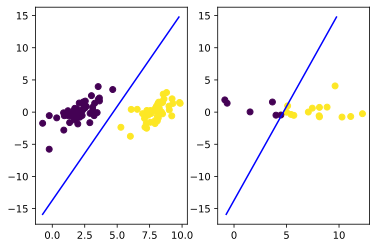

In [7]:
def generate_test_data(amount):
    data = np.zeros((amount, 2))
    
    data[:, 0] = np.random.normal(4.79, 3.1, amount)
    data[:, 1] = np.random.normal(0, 1.46, amount)
    
    return data

def test_predict():
    train_data, train_label = load_dataset('linear_separable.txt')
    
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.scatter(train_data[:,0], train_data[:,1], c=train_label)
    
    s = svm.SVMBySMO(train_data, train_label, 0.6, 1e-3, max_iter=40)
    
    line_x, line_y = get_decision_boundary(train_data, train_label, *s.get_params())
    ax1.plot(line_x, line_y, c='b')
    
    test_data = generate_test_data(20)
    predict_label = s.predict(test_data)
    
    ax2 = fig.add_subplot(122)
    ax2.scatter(test_data[:,0], test_data[:,1], c=predict_label)
    ax2.plot(line_x, line_y, c='b')
    
test_predict()

                0           1           2
count  100.000000  100.000000  100.000000
mean     0.033447    0.105926   -0.120000
std      0.438134    0.407107    0.997775
min     -0.908298   -0.753885   -1.000000
25%     -0.266502   -0.128890   -1.000000
50%      0.052210    0.037005   -1.000000
75%      0.306965    0.436906    1.000000
max      0.957812    0.995685    1.000000


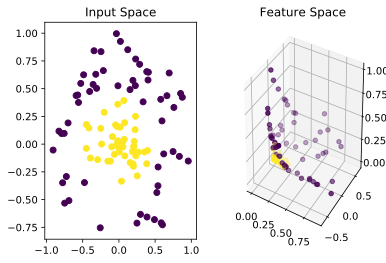

In [8]:
def explore_non_linear_separable_data():
    df = pd.read_csv('nonlinear_separable_train.txt', sep='\t', header=None)
    print(df.describe())

    fig = plt.figure()

    # we plot in input space first
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Input Space')
    ax1.scatter(df[0], df[1], c=df[2])

    # we can see that this dataset is indeed nonlinear separable,
    # then we apply a kernel trick, use polynomial kernel function
    # to map the dataset to another space.
    input_X, Y = df.iloc[:, :2].to_numpy(), df.iloc[:, -1].to_numpy()
    N = input_X.shape[0]

    # we map R^2 to R^3
    feature_X = np.zeros((N, 3))
    feature_X[:, 0] = input_X[:, 0] ** 2
    feature_X[:, 1] = np.sqrt(2) * input_X[:, 0] * input_X[:, 1]
    feature_X[:, 2] = input_X[:, 1] ** 2

    # plot in feature space
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.title.set_text('Feature Space')
    ax2.scatter3D(feature_X[:, 0], feature_X[:, 1], feature_X[:, 2], c=Y)
    
explore_non_linear_separable_data()

Kernel function used in above mapping:

$$\begin{aligned}
x &\in R^2 \\
\phi: &\; R^2 \mapsto R^3 \\
\phi(x) &= \left( (x^{(1)})^2, \sqrt{2} x^{(1)} x^{(2)}, (x^{(2)})^2 \right)
\end{aligned}$$

We can drag the 3D scatter plot above(need ipympl support) to see that classification can be achieved
by a plane in feature space.

support vector amount: 88
corresponding alphas: [0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6]
b in smo: 9.64170368662074


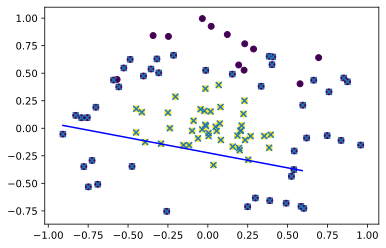

In [9]:
# what will happen if we still use linear method on above nonlinear separable data?
def test_linear_method_on_nonlinear_separable_data():
    train_data, train_label = load_dataset('nonlinear_separable_train.txt')
    s = svm.SVMBySMO(train_data, train_label, 0.6, 1e-3, max_iter=100)
    visualize_dataset_with_decision_boundary(train_data, train_label,
            *s.get_params())
    
test_linear_method_on_nonlinear_separable_data()

# we can see that most $\alpha == C$, this means that most $\xi \neq 0$,
# most of them are misclassified.

support vertor amount: 5
support vertor amount: 6


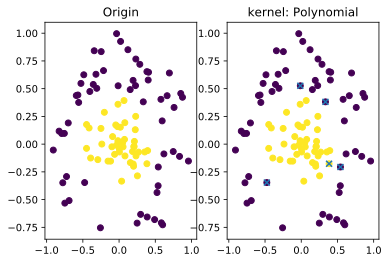

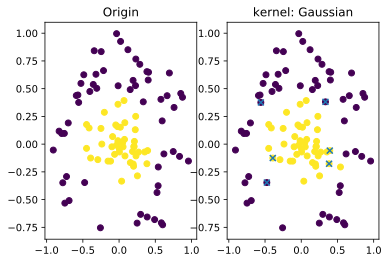

In [10]:
# Let's play with kernel trick.
def explore_kernel_trick(kernel, C):
    train_data, train_label = load_dataset('nonlinear_separable_train.txt')
    
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.scatter(train_data[:,0], train_data[:,1], c=train_label)
    ax1.title.set_text('Origin')
    
    s = svm.SVMBySMO(train_data, train_label, C, 1e-4, kernel=kernel, max_iter=20000)
    # we try to verify that our kernel implementation, so we just predict on train_data
    predict_label = s.predict(train_data)
    
    ax2 = fig.add_subplot(122)
    ax2.scatter(train_data[:,0], train_data[:,1], c=predict_label)
    ax2.title.set_text('kernel: {}'.format(kernel[0]))
    
    # plot support vector
    alphas = s.get_params()[0]
    support_vector_idx = np.nonzero(np.logical_and(0 < alphas, alphas < C))[0]
    ax2.scatter(train_data[support_vector_idx,0],
                train_data[support_vector_idx,1],
                marker='x')
    
    print('support vertor amount:', support_vector_idx.size)

# we check Polynomial kernel first
explore_kernel_trick(('Polynomial', 2), 200)

# then check Gaussian kernel
explore_kernel_trick(('Gaussian', 1.3), 100)

In [11]:
def calculate_accuracy(Y, predict_Y):
    return (Y == predict_Y).sum() / Y.size

def test_accuracy_on_nonlinear_separable(**kwargs):
    train_data, train_label = load_dataset('nonlinear_separable_train.txt')
    test_data, test_label = load_dataset('nonlinear_separable_test.txt')
    
    s = svm.SVMBySMO(train_data, train_label, **kwargs)
    predict_label = s.predict(test_data)
    
    accuracy = calculate_accuracy(test_label, predict_label)
    print('accuracy:', accuracy)
    
test_accuracy_on_nonlinear_separable(C=200, epsilon=1e-4,
    kernel=('Polynomial', 2), max_iter=20000)

test_accuracy_on_nonlinear_separable(C=100, epsilon=1e-4,
    kernel=('Gaussian', 1.3), max_iter=20000)

accuracy: 0.96
accuracy: 0.94
